# Player Engagement Based on Past Participation 

## Introduction

This project focuses on assisting a computer science research group at The University of British Columbia that is looking into player behaviour in video games. Specifically, the research involves a Minecraft server which tracks player movements and actions and how they interact with the world. 

The research group need to target their recruitment efforts to make sure they have enough resources and have enough players to get an ample amount of data. They want to answer the research question: *We would like to have a good model of whether or not a player will continue contributing given past participation?*

Answering this question is crucial to helping the research group optimize their recruitment. Therefore, by leveraging data science and machine learning techniques, this project aims to predict those player engagement patterns.

### Data
The data comes in two different datasets, the players data and the sessions data. For this analysis, the focus will be solely on the players dataset. The data contained in the sessions data was deemed not needed for the purpose of the question asked above. Nevertheless, the desciption of the dataset is still there for those who wish to know.

#### Players Data
The player's dataset has 9 variables with 196 observations. It captures user information on for the minecraft server.
- experience: A categorical variable that describes the user's experience level with Minecraft. The categories range from - "Beginner", "Amateur", "Regular", "Pro", "Veteran".
- subscribe: A logical data variable, which is either TRUE, FALSE or NA. In this case, there is only TRUE or FALSE. This variable represents if the player is subscribed to the server's email updates.
- hashedEmail: A string variable of a hashed representation of the email the player used to sign up with.
- played_hours: A numeric variable detailing the total hours a user has spent on the server.
- name: A string variable representing the first name of the player.
- gender: a string variable representing the player's gender.
- age: A numeric variable representing the player's age.
- individualId: The variable is empty throughout the entire dataset but appears to be just a unique identifier for the player.
- organizationName: The variable is empty throughout the entire dataset but appears to capture the organization with which the player is associated.

#### Sessions Data
The player's dataset has 5 variables with 1535 observations. It captures video game session information for a player. It is linked to the player through the hashedEmail thus the two tables could be combined into one dataset to give more information.
- hashedEmail: A string variable representing the hashed email of a player.
- start_time: A string variable representing the start time of the session in the format of DD/MM/YYYY HH:MM
- end_time: A string variable representing the end time of the session in the format of DD/MM/YYYY HH:MM
- original_start_time: A numerical variable representing the start time of the session in UNIX timestamp format (number of seconds since January 1, 1970 (UTC)).
- original_end_time: A numerical variable representing the end time of the session in UNIX timestamp

In [1]:
library(tidyverse)
library(ggplot2)
library(repr)
library(readr)  
library(dplyr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Downloading Data

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read.csv(players_url)

In [3]:
head(players_data)

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>,<lgl>,<lgl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


## Wrangling
The following steps do some light intial preprocessing and wrangling.

Drop unneeded columns and set `subscribe` as the target variable.

In [4]:
players <- players_data |>
    select(-individualId, -organizationName, -name, -hashedEmail) |>
    drop_na() |>
    mutate(subscribe = as_factor(subscribe))

head(players)

,experience,subscribe,played_hours,gender,age
,<chr>,<fct>,<dbl>,<chr>,<int>
1,Pro,TRUE,30.3,Male,9
2,Veteran,TRUE,3.8,Male,17
3,Veteran,FALSE,0.0,Male,17
4,Amateur,TRUE,0.7,Female,21
5,Regular,TRUE,0.1,Male,21
6,Amateur,TRUE,0.0,Female,17


View the structure of the dataset.

In [5]:
str(players)

'data.frame':	196 obs. of  5 variables:
 $ experience  : chr  "Pro" "Veteran" "Veteran" "Amateur" ...
 $ subscribe   : Factor w/ 2 levels "FALSE","TRUE": 2 2 1 2 2 2 2 1 2 2 ...
 $ played_hours: num  30.3 3.8 0 0.7 0.1 0 0 0 0.1 0 ...
 $ gender      : chr  "Male" "Male" "Male" "Female" ...
 $ age         : int  9 17 17 21 21 17 19 21 17 22 ...


Summary of the `subscribe` target variable.

In [6]:
subscribe_summary <- players |>
    group_by(subscribe) |>
    summarize(count = n(), percentage = 100 * count / nrow(players))

subscribe_summary

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


Summary of numerical explanatory variables. 

Some things to note:
- The average hours played is heavily skewed due to the players who play a lot.
- The median hours played only show 0.1 meaning players typically don't play that many hours. 

In [7]:
numerical_summary <- players |>
  summarize(across(
    where(is.numeric),
    list(
      mean = \(x) mean(x, na.rm = TRUE),
      sd = \(x) sd(x, na.rm = TRUE),
      median = \(x) median(x, na.rm = TRUE)
    )
  ))

numerical_summary

played_hours_mean,played_hours_sd,played_hours_median,age_mean,age_sd,age_median
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,28.35734,0.1,21.28061,9.706346,19


Summary of categorical explanatory variables. 

These variables will need to be one hot encoded. There are 5 and 7 unique categories for experience and gender respectively.

In [8]:
categorical_summary <- players |>
    summarize(across(where(is.character), ~ length(unique(.)), .names = "unique_{.col}"))

categorical_summary

unique_experience,unique_gender
<int>,<int>
5,7


## Visualizations

`player_hours` vs `age` by `subscribe`. Can potentially show a linear trend line or clusters for the variables. The graph below doesn't show too much of a relationship. 

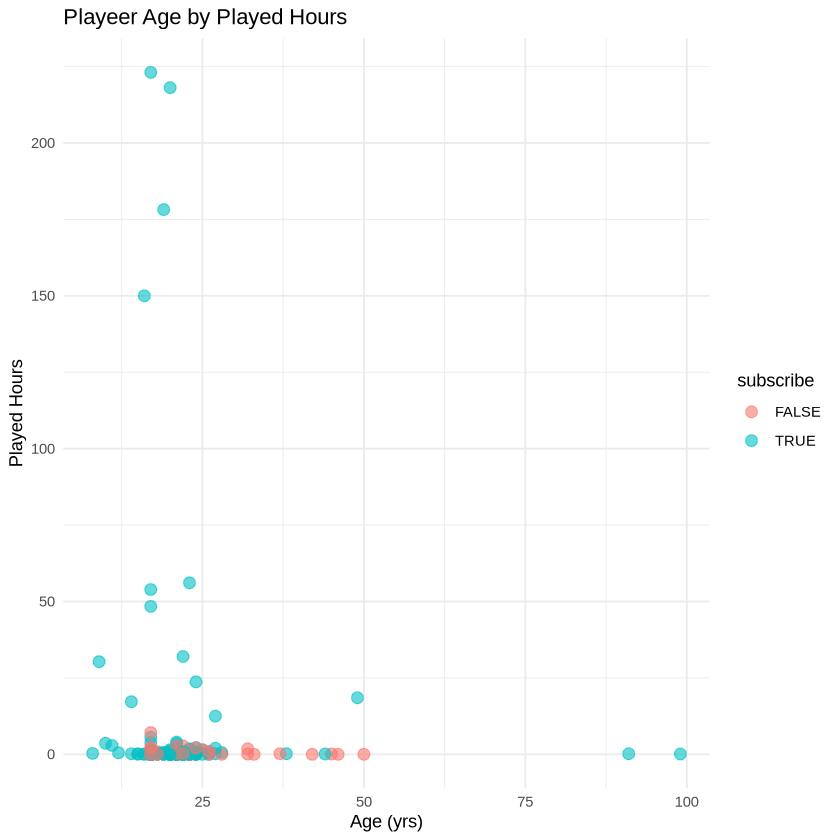

In [9]:
ggplot(players, aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(size = 3, alpha = 0.6) +
    labs(title = "Playeer Age by Played Hours",
         x = "Age (yrs)",
         y = "Played Hours") +
    theme_minimal()

`age` distribution by `subscribe`. Can show how age varies across subscribe categories. A much larger proportion of younger people are subscribed. This is also probably because that age category dominates the dataset. 

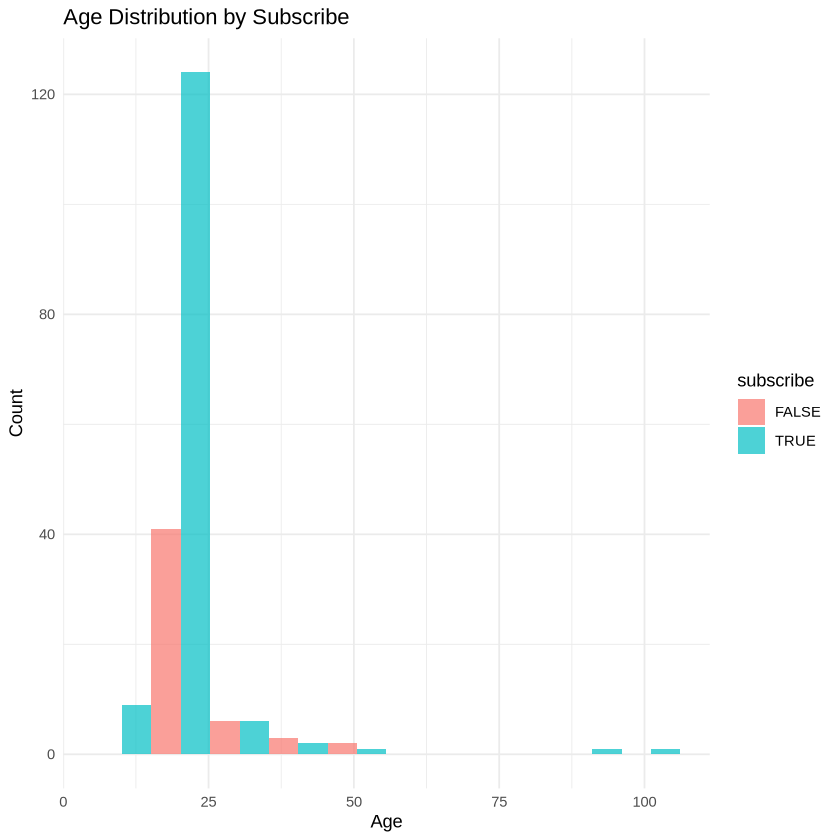

In [10]:
ggplot(players, aes(x = age, fill = subscribe)) +
    geom_histogram(position = "dodge", bins = 10, alpha = 0.7) +
    labs(title = "Age Distribution by Subscribe", x = "Age", y = "Count") +
    theme_minimal()

Bar plot showing the proportion of players of each `gender` in each `subscribe` category. Can highlight gender-specific trends. This graph is showing that males dominate the gender proportions but the `subscribe` target is spread somewhat evenly across all genders.

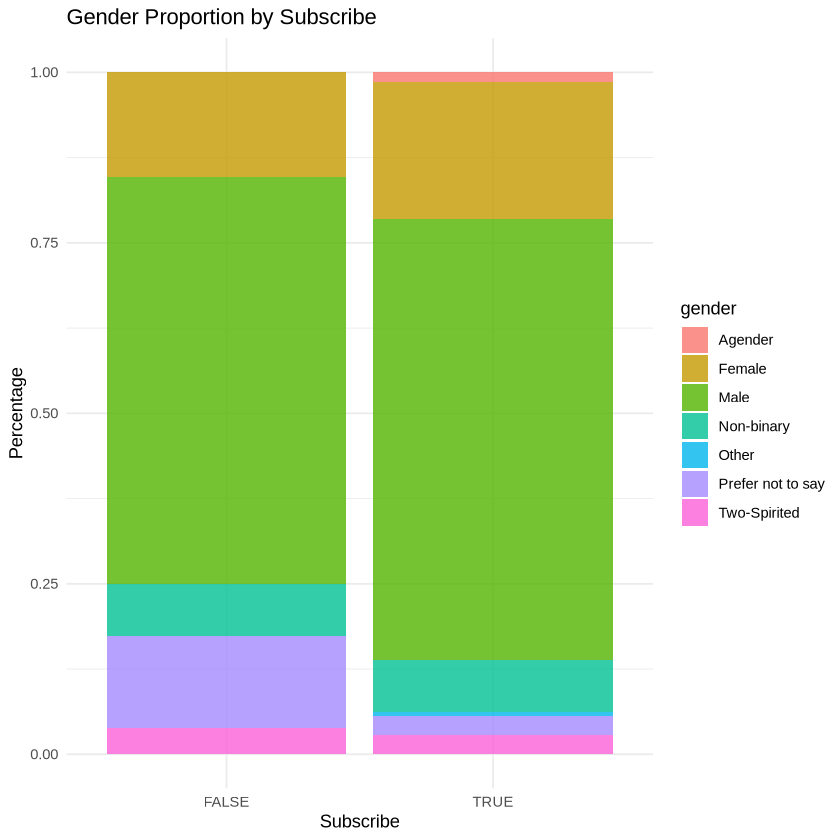

In [11]:
ggplot(players, aes(x = subscribe, fill = gender)) +
    geom_bar(position = "fill", alpha = 0.8) +
    labs(title = "Gender Proportion by Subscribe", x = "Subscribe", y = "Percentage") +
    theme_minimal()

Bar plot showing the proportion of players of each `experience` in each `subscribe` category. Can highlight experience-specific trends. This graph is showing that there is a relatively even relationship between `experience` and whether or not a player is subscribed or not. 

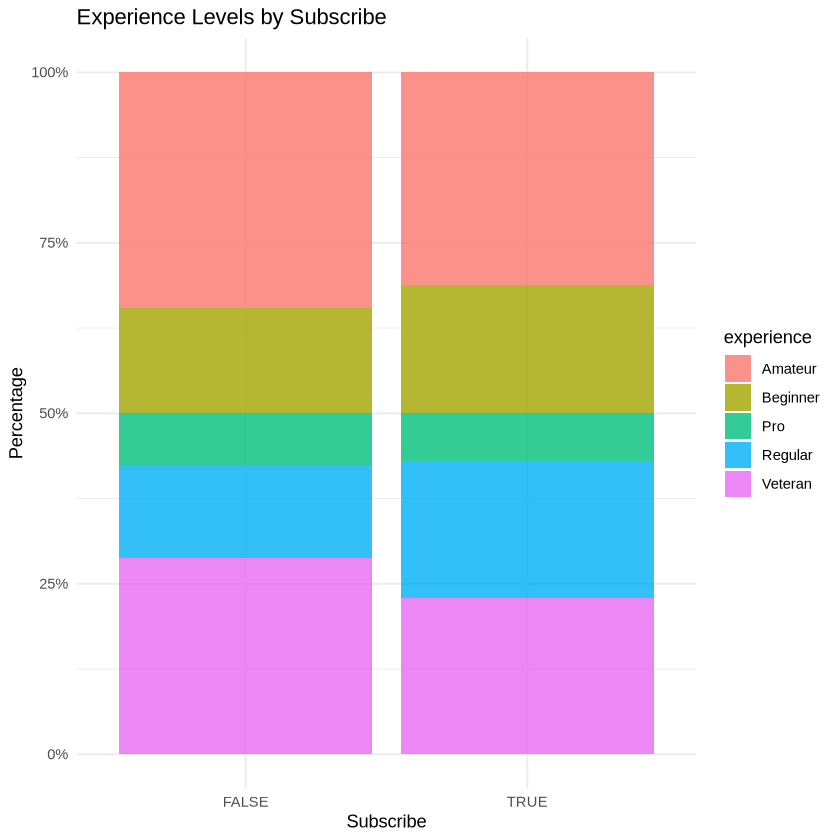

In [12]:
ggplot(players, aes(x = subscribe, fill = experience)) +
    geom_bar(position = "fill", alpha = 0.8) +
    scale_y_continuous(labels = scales::percent) +
    labs(title = "Experience Levels by Subscribe", x = "Subscribe", y = "Percentage") +
    theme_minimal()

Overall, there wasn't a specific trend that stood out between the explanatory variables and the target. Will continue forward to the data analysis. 

## Analysis

Splitting into train and test sets.

In [13]:
set.seed(2024) 

players_split <- initial_split(players, prop = 0.75, strata = "subscribe")
players_train <- training(players_split)
players_test <- testing(players_split)

Creating the recipe:
- Scaling numerical variables
- One-hot encoding categorical variables

In [14]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_novel(all_nominal_predictors()) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors()) |>
    step_dummy(all_nominal_predictors())

Since there was no linear relationship easily identified in the exploratory data analysis, this report will only focus on k-nearest neighbours (knn). Below is trying a knn model without hyperparameter tuning.

In [15]:
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_mode("classification") |>
  set_engine("kknn")

players_knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_knn_spec) |>
  fit(data = players_train)

Trying the model on the training data and report the accuracy, precision and recall. 

In [16]:
players_train_predictions <- predict(players_knn_fit , players_train) |>
    bind_cols(players_train)

accuracy <- players_train_predictions |>
    accuracy(truth = subscribe, estimate = .pred_class)

precision <- players_train_predictions |>
    precision(truth = subscribe, estimate = .pred_class)

recall <- players_train_predictions |>
  recall(truth = subscribe, estimate = .pred_class)

metrics <- bind_rows(accuracy, precision, recall)
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7959184
precision,binary,0.7368421
recall,binary,0.3589744


On the training set, accuracy and recall aren't bad. The recall is quite low, indicating that it misses a large number of actual positives. This can be viewed in the confusion matrix below.

In [17]:
confusion_matrix_result <- players_train_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix_result

          Truth
Prediction FALSE TRUE
     FALSE    14    5
     TRUE     25  103

### kNN Tuning

Perform kNN tuning to find the best k and also perform cross validation.

In [18]:
set.seed(2024)

players_knn_spec_tune <- nearest_neighbor(neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [19]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [20]:
players_knn_tune_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

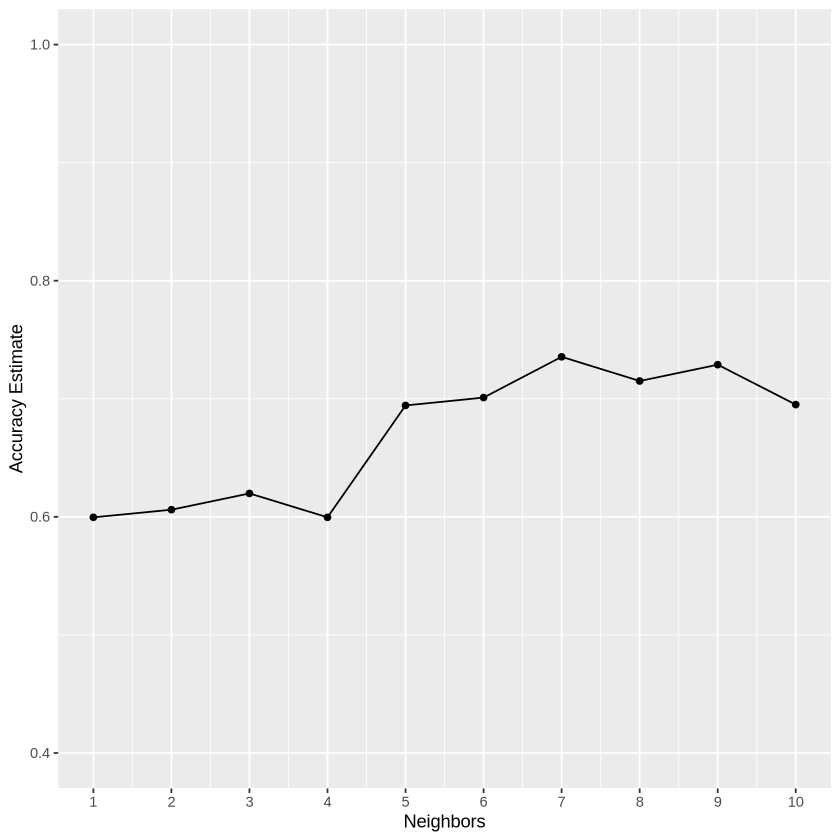

In [21]:
accuracies <- players_knn_tune_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

Looking at the graph, the final model will choose k = 7 since it has the close to the highest accuracy estimate without making the model too complex (k = 10). One could also make the argument for k = 6 to again, not make the model too complex. 

In [22]:
best_k <- players_knn_tune_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
best_k

[1] 7

### Finalize and fit the best model

In [23]:
set.seed(2024)

players_knn_spec_final <- nearest_neighbor(neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_knn_fit_final <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_knn_spec_final) |>
  fit(data = players_train)

In [24]:
players_test_predictions <- predict(players_knn_fit_final, players_test) |>
    bind_cols(players_test)

head(players_test_predictions)

.pred_class,experience,subscribe,played_hours,gender,age
<fct>,<chr>,<fct>,<dbl>,<chr>,<int>
TRUE,Amateur,TRUE,0.1,Male,17
TRUE,Amateur,TRUE,48.4,Female,17
FALSE,Regular,TRUE,0.6,Male,19
TRUE,Regular,TRUE,0.0,Male,17
TRUE,Veteran,FALSE,0.0,Male,23
TRUE,Veteran,FALSE,0.1,Male,18


Looking at the accuracy, precision and recall.

In [25]:
test_accuracy <- players_test_predictions |>
    accuracy(truth = subscribe, estimate = .pred_class)

test_precision <- players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class)

test_recall <- players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class)

test_metrics <- bind_rows(test_accuracy, test_precision, test_recall)
test_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.63265306
precision,binary,0.14285714
recall,binary,0.07692308


In [26]:
confusion_matrix_test_result <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix_test_result

          Truth
Prediction FALSE TRUE
     FALSE     1    6
     TRUE     12   30

## Dicussion

After the "Players Data" was wrangled and pre-processed with the response variable as "subscribe" and explanatory variables: "gender", "age", "played_hours", and "experience" with the "subscribe" variable converted into a factor form for classification and missing values omitted. 
The played_hours variable is heavily skewed, with the mean at 5.85 hours and a median of 0.1 hours which indicates that most players' engagement is low due to a low amount of hours played. 

The age variable has a mean of 21.28 years and a median of 19 years, and a high standard deviation of 9.7, which shows a wide age range with a a high magnitude of younger people being subscribed. Looking at the proportion of the age groups from the created visualizations, a higher amount of younger players are subscribed and in terms of gender distributions, even distribution among subscribers is seen amongst all gender categories except males are at a greater peak. Finally, in terms of experience levels, there is even distribution amongst subscribed and unsubscribed players which indicates that the "experience" variable doesn't greatly shape or impact the predictivity of "subscription" unlike the other explanatory variables. 

K-NN classification was chosen due to the lack of linear relationships in the dataset between the explanatory variables and the target variable and so with the initial training of the model with k=5, a moderate accuracy of 79.6% was found with a low recall of 35.9%. The accuracy demonstrates that the model had a 79.6% chance of predicting whether or not a player is subscribed or not but a low recall variable shows that the model had a low extent of finding the actual amount of subscribers. In terms of the confusion matrix, the model indicated "subscribed" for many of the players who weren't subscribed in reality which is indicative of the case of far too many non-subscribed players. There are 12 false positives which represent the model incorrectly predicted that the player is subscribed and one true negative which is the case where the model correctly predicted that the player is not subscribed. Overall, this shows teh model favoring the major class, being "not subcribed". There are only 30 true positives which are representative of where the model correctly predicted that the player is subscribed but 6 false negatives which are indicative of the model incorrectly predicting that the player is not subscribed so in conclusion, the model did have a low predict power over identifying subscribed players compared to not subscribed payers. Additionally, a precision value of 73.7% was evident which shows that the model moderately performs well in terms of predicting positives but also shows a great number of false positives. 

After tuning the model, a k value of 7 and metrics on the test data show a lower accuracy, precision, and recall which shows that the model performs better on the training data compared to the test data but it raises the questions of overfitting where the model has a hard time in performance ability to generalize to new data. These findings are expected since it is common to see better metrics for the training data due to the training data not being unknown to the model in terms of its patterns. However, this poses an impact on the findings since the model's performance level is low when faced with unseen data so it could lead to unreliable predictions when faced with real, external, and unseen data. This leads to future questions such as how we can combat this issue by increasing the accuracy, precision, and recall values of the test data. Additional tuning of the model can be accomplished along with other models such as logistic regression and decision trees.



